# The Quantum Fourier Transform 

One of the Most fundamental parts of many quantum algorithms is the QFT. We can take a discrete Fourier transform of the probability amplitudes of a wavefunction. 

It makes something powerful, like Shor's algorithm feasible and impressive. 

The math is a little tricky so please do practice carrying out calculations, we will cover teh implementation in Qiskit. 


### Review some math 

Essentially the fourier transform is a mapping of $|j\rangle$ states to $|k\rangle$ states, using this relationship,

$$|j\rangle \rightarrow \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} e^{2\pi i \frac{jk}{N}} |k\rangle $$

Going from $|j\rangle$ to $|k\rangle$ can be shown using a Quantum operator $U_{QFT}$, 

$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1}  \sum_{k=0}^{N-1} e^{2\pi i \frac{jk}{N}} |k\rangle \langle j| $$


### The Gate Keepers of the QFT 

There are two (three maybe one) essential gates that allow us to implement the QFT. 

* We First Apply the Hadamard gate to the first qubit.

* Next apply a Controlled Rotation (CROT) on the first and second qubit, then the first and third, then the first and fourth....then the first and last qubit. 

* Apply the Hadamard gat to the second qubit.

* Apply CROT between second and third qubit, second and fourth....second and last qubit. 

* Continue this patternt unitl you just apply the Hadamard gate to the final qubit.

* Swap each n qubit with its N-n partner, so the first 0th qubit gets swapped with the N-0 qubit, the last qubit. The second, 1st qubit gets swapped with the N-1, second to last qubit etc. 

### CROT 

CROT is a controlled rotation gate rotates our qubit, giving it a phase, in Qiskit its just called a controlled phase gate (CP). It takes some value theta to rotate our target qubit, this value will change everytime we rotate each successive qubit. We will follow, 

$$ \theta = \frac{\pi}{2^{k-1}} $$ 

We will rotate each first qubit by $\frac{\pi}{2}$ and the next $\frac{\pi}{4}$ and so on and so forth. 

### Qiskit implementation

We can Create a really useful function that will make the circuit for us, for more reference please check out the [QFT](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html#3.-Example-1:-1-qubit-QFT-) from the qiskit textbook. 

I will walk you through the process of the code, essentially we will do the same protocol backwards (swaps at the end). We will apply H and CROT to the last qubit and then work our way up, this works out because of how Qiskit prints out states, that is most significant qubit first, and that we can use a powerful tool when writing functions called recursion, that allows us to call our function inside it self to carry on the H and CROT pattern until the whole entire function has been passed through. 

How do we implement this in Qiskit? 


## Imports ( Import Pi from Python math) 

In [1]:
# Do not forget to Import Qiskit 

from qiskit.visualization import * 
from qiskit import * 

S_simulator=Aer.backends(name='statevector_simulator')[0] 
M_simulator=Aer.backends(name='qasm_simulator')[0] 

from math import pi


## Creating a function to apply H and CROT (CP) 

In [2]:
# lets make a fucntions called rotate we do this in python by using def and 
# then the function name along with the variables we want our function to take and a colon

def rotations(circuit, n): 
    
    # if we went through the whole circuit, we do not have to do anymore work
    # just return the circuit we made
    if n == 0: 
        return circuit 
    
    
    # circuit is the QuantumCircuit we want to use the qft on, 
    # n is the number of qubits in the circuit 
    n-=1 # 4th qubit is in the n=3 spot on the circuit
        # mth qubit is on the n=m-1 spot on the circuit
        # also allows us to reduce down to n = 0 and to stop doing the rotations
        
    circuit.h(n) # Apply Hadamard gate to the qubit we are currently working on
    
    for qubit in range(n): 
        
        # now use controlled phase gate to rotate 
        # also divide the rotation angle by 2 each time 
        
        circuit.cp(pi/2**(n-qubit), qubit, n) # circuit.cp() takes three arguments 
                                            # (theta, target qubit, control qubit) 
            
        #so the first time through in this loop the dummy  variable 
        # "qubit" is 0 , so we will do rotation of of pi/2**(n-0) on the 0th qubit using the
        # nth qubit as a control qubit. And so on and so forth. 
        
        
    rotations(circuit, n) # do the same thing to the next qubit     


Lets Draw out what we have for an example of 5 qubits

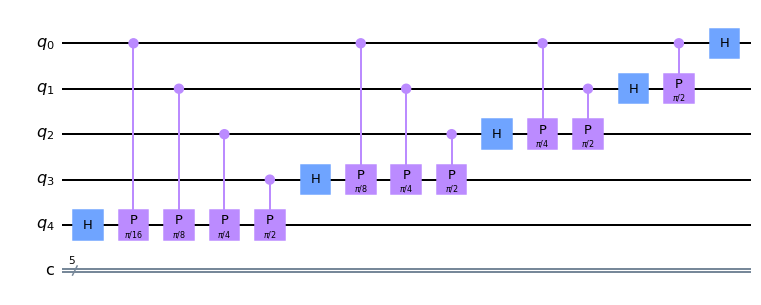

In [3]:
qc = QuantumCircuit(5,5)
rotations(qc,5)
qc.draw(output='mpl')

That looks great! Now we just need to swap our registers, we can make a function for that, and put both our rotations and swap functions together to make a new function that does the QFT seamlessly! (uberly does not have the same ring to it) 

In [4]:
def swap_qubits(circuit,n): 
    
    # only need to loop through half of the circuit, since we swap two qubits at a time
    
    for qubit in range(n//2): # // floor function helps us round down when we have odd qubits 
        circuit.swap(qubit, n-qubit-1)
    return circuit 

def qft(circuit, n): 
    
    rotations(circuit, n)
    swap_qubits(circuit,n)
    return circuit

All together now! 

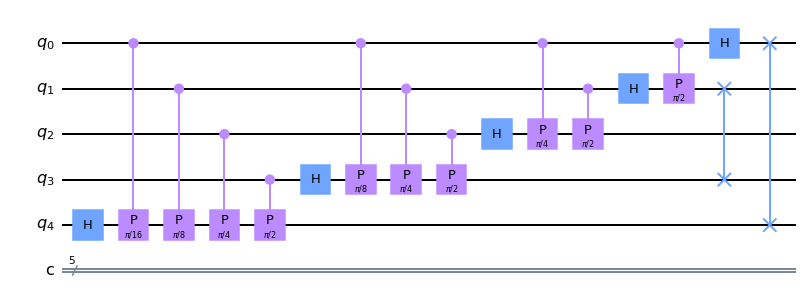

In [5]:
qc=QuantumCircuit(5,5)
qft(qc,5)
qc.draw(output='mpl')

In [6]:
# Note see how the 3rd qubit does not get swapped since it would swap with itself

## Example (This is a little bit of an exploration to try and show what this does and mean, this section is admitedly sloppy you do not need it just hoping it can be cool to add to what you already learned) 

In [7]:
# Lets take some state x and put it in the QFT and see what we get out 

x=10 

from math import log 
def find_number_of_qubits(x): 
    
    powers_of_two=0
    exponent=0
    while powers_of_two<x:
        powers_of_two=2**exponent
        exponent+=1
    
    number_of_qubits = int(log(powers_of_two,2))
    return number_of_qubits

n = find_number_of_qubits(x)  

encoding = bin(x) 
# encoding has an extra '0b' that just says hey i am a binary number we can chop it off 
# by replacing it with nothing 

print('State we need to encode to try out qft: ', encoding.replace('0b', ''))

State we need to encode to try out qft:  1010


We can encode our state by reading the binary and flipping qubits 

1010 is in the little endian encoding, the most significant bit is on the left, 
the least significant bit is on the right so this reads 
1*(2^3) + 0*(2^2) + 1*(2^1) + 0*(2^0) = 8 + 2 = 10 

I like to read circuits top bottom so I would read this as big endian encoding so in reverse
like 0101 

BUT we are reversing the circuit anyway, so let us just read it in the way qiskit likes it makes things simpler. 

so lets use an x gate on the first qubit and third qubit so we can encode 1010 into our circuit and do the qft 

In [8]:
qc = QuantumCircuit(n,n) # number of qubits calculated before 

qc.x(0)
qc.x(2)

qc.barrier() # seperate steps with a barrier. 

print('state before QFT: ', execute(qc, S_simulator).result().get_statevector())

qft(qc, n)

print('state after QFT: ', execute(qc, S_simulator).result().get_statevector())


state before QFT:  [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
state after QFT:  [ 2.50000000e-01-6.12323400e-17j -9.56708581e-02+2.30969883e-01j
 -1.76776695e-01-1.76776695e-01j  2.30969883e-01-9.56708581e-02j
  7.65404249e-17+2.50000000e-01j -2.30969883e-01-9.56708581e-02j
  1.76776695e-01-1.76776695e-01j  9.56708581e-02+2.30969883e-01j
 -2.50000000e-01+6.12323400e-17j  9.56708581e-02-2.30969883e-01j
  1.76776695e-01+1.76776695e-01j -2.30969883e-01+9.56708581e-02j
 -7.65404249e-17-2.50000000e-01j  2.30969883e-01+9.56708581e-02j
 -1.76776695e-01+1.76776695e-01j -9.56708581e-02-2.30969883e-01j]


0.250000 -0.000000 j
-0.095671 0.230970 j
-0.176777 -0.176777 j
0.230970 -0.095671 j
0.000000 0.250000 j
-0.230970 -0.095671 j
0.176777 -0.176777 j
0.095671 0.230970 j
-0.250000 0.000000 j
0.095671 -0.230970 j
0.176777 0.176777 j
-0.230970 0.095671 j
-0.000000 -0.250000 j
0.230970 0.095671 j
-0.176777 0.176777 j
-0.095671 -0.230970 j


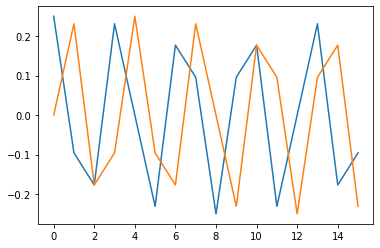

In [9]:
# Our output is a little messy lets grab the state and clean it up

state = execute(qc, S_simulator).result().get_statevector()

# we use formatting %f to print trimmed version of the real and complex parts of each amplitude 

# this is cool to pick up but do not worry too much about this 

real=[]
imag=[]
for i in state: 
    
    print('%f' % i.real, '%f' % i.imag , 'j')
    
# We see that we get a weird repeating signal or wave of values for a constant state 
    real.append(i.real)
    imag.append(i.imag)
    
from matplotlib import pyplot as plt 

plt.plot(range(len(state)), real)
plt.plot(range(len(state)), imag)

plt.show()

In [10]:
# What would we get if we take an input where we have an even superposition of all states. 
from math import sqrt 
n=3 

a= sqrt(1/(2**n)) # amplitude 

state=[a,a,a,a,a,a,a,a]

qc=QuantumCircuit(3)

qc.initialize(state, [0,1,2]) 

qc.barrier() # seperate steps with a barrier. 

print('state before QFT: ', execute(qc, S_simulator).result().get_statevector())

qft(qc, n)

print('state after QFT: ', execute(qc, S_simulator).result().get_statevector())




state before QFT:  [0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
state after QFT:  [ 1.00000000e+00-1.83697020e-16j -2.62909324e-17+4.10582171e-17j
 -4.68750097e-17+1.43573302e-17j  4.32523755e-18+1.97261092e-17j
 -3.58404070e-17+6.12323400e-17j  1.70068704e-17+1.08900608e-17j
  1.43573302e-17+4.68750097e-17j  4.76230404e-17-1.04420472e-17j]


1.000000 -0.000000 j
-0.000000 0.000000 j
-0.000000 0.000000 j
0.000000 0.000000 j
-0.000000 0.000000 j
0.000000 0.000000 j
0.000000 0.000000 j
0.000000 -0.000000 j


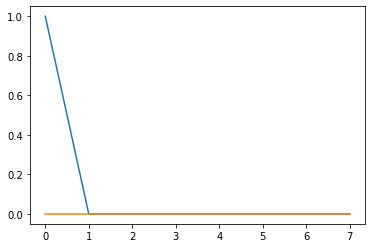

In [11]:
# Our output is a little messy lets grab the state and clean it up

state = execute(qc, S_simulator).result().get_statevector()

# we use formatting %f to print trimmed version of the real and complex parts of each amplitude 

# this is cool to pick up but do not worry too much about this 

real=[]
imag=[]
for i in state: 
    
    print('%f' % i.real, '%f' % i.imag , 'j')
    
# We see that we get a weird repeating signal or wave of values for a constant state 
    real.append(i.real)
    imag.append(i.imag)
    
from matplotlib import pyplot as plt 

plt.plot(range(len(state)), real)
plt.plot(range(len(state)), imag)

plt.show()

# Discussion

we see that taking the QFT of an equal superposition of multiple states produces a single state! 

The graphs are kind of confusin but notice how we got oscillatory behavior when we put in a single state with probability of 1 , and got the opposite when we put in an equal superposition of many states! 